In [2]:
##%%
import os
from os.path import join as pjoin
from tifffile import imread, imwrite
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter,median_filter
from NatMovie_utils import *
from wfield import *
from cor470 import enhance_df_f
sys.path.append('./ICA')
from jadeR import jadeR
from jadeR_cupy import jadeR_cupy


In [3]:
def IOU(cluster1,cluster2):
    """
    cluster1: binary image
    cluster2: binary image
    """
    intersection = np.logical_and(cluster1,cluster2).sum()
    union = np.logical_or(cluster1,cluster2).sum()
    if union == 0:
        return 0
    else:
        return intersection/union

In [4]:
def maxIOU(A, B):
    Ai_IOU=np.zeros(B.shape[0])
    A_maxIOU=np.zeros(A.shape[0])

    for i_IC in range(A.shape[0]):
        for j_IC in range(B.shape[0]):
            Ai_IOU[j_IC]=IOU(A[i_IC], B[j_IC])
        A_maxIOU[i_IC]=Ai_IOU.max()
        
    return A_maxIOU



In [5]:
def cal_list_IOU(experiment_IC_list, experiment_name_list):
    """
    计算变量列表中两两之间的 maxIOU.
    
    参数：
    experiment_IC_list: list of np.ndarray
        长度为 n 的变量列表，每个变量是三维数组 (n_IC, height, width)。
    experiment_name_list: list of str
        对应的变量名列表，长度为 n。
        
    返回：
    max_iou_df: pd.DataFrame
        一个 n*n 的 DataFrame，每个元素是两个变量之间的 maxIOU 数组。
    """
    n = len(experiment_IC_list)
    if len(experiment_name_list) != n:
        raise ValueError("变量列表和变量名列表长度不匹配。")
    
    # 创建一个 n x n 的 DataFrame 存储 maxIOU 数据
    max_iou_df = pd.DataFrame(index=experiment_name_list, columns=experiment_name_list, dtype=object)
    
    for i in range(n):
        for j in range(n):
            # 计算 maxIOU(A, B)
            max_iou = maxIOU(experiment_IC_list[i], experiment_IC_list[j])
            max_iou_df.iloc[i, j] = max_iou  # 存入 DataFrame
    
    return max_iou_df


In [15]:
def plot_IOU(max_iou_df, fig_path=None, fig_title=None):
    """
    绘制IOU箱线图。
    
    参数：max_iou_df: pd.DataFrame
        一个 n*n 的 DataFrame，每个元素是两个变量之间的 maxIOU 数组。
    """
    n = max_iou_df.shape[0]
    
    # 创建一个 n x n 的子图
    fig, axes = plt.subplots(n, n, figsize=(15, 15))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    
    for i in range(n):
        for j in range(n):
            ax = axes[i, j]
            
            # # 对角线留空
            # if i == j:
            #     ax.axis('off')
            #     continue
            
            max_iou = max_iou_df.iloc[i,j]
            # 绘制箱线图
            bp = ax.boxplot(max_iou, patch_artist=True, showfliers=False, widths=0.5, boxprops=dict(facecolor='none'))
            # 叠加散点图
            x_positions = np.full_like(max_iou, 1, dtype=float) + np.random.uniform(-0.1, 0.1, size=max_iou.shape)
            ax.scatter(x_positions, max_iou, color='blue', alpha=0.7, s=10, label='Data Points')
            
            ax.set_ylim(0, 1)
            ax.set_xticks([])
            ax.set_title(f"{max_iou_df.index[i]} vs {max_iou_df.columns[j]}")

    # # 添加行名和列名
    # for i in range(n):
    #     # 行名在最左侧
    #     axes[i, 0].set_ylabel(max_iou_df.index[i], rotation=0, labelpad=30, fontsize=12, ha='right', va='center')
    #     # 列名在顶部
    #     axes[0, i].set_xlabel(max_iou_df.columns[i], labelpad=10, fontsize=12, ha='center')
    #     axes[0, i].xaxis.set_label_position('top')
            
    fig.set_facecolor('white') 
    if fig_title:
        fig.suptitle(fig_title, fontsize=30, y=0.99)
           
    if fig_path:
        plt.savefig(fig_path, bbox_inches='tight')
    plt.show()
    

In [26]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_IOU(max_iou_df, fig_path=None, fig_title=None, stat_test=False, significance=0.05):
    """
    绘制 IOU 箱线图，并进行两两组间的统计检验（Mann-Whitney U 检验）。

    参数：
        max_iou_df: pd.DataFrame
            一个 n*n 的 DataFrame，每个元素是两个变量之间的 maxIOU 数组。
        fig_path: str, optional
            保存图像的路径。
        fig_title: str, optional
            图像标题。
        perform_stat_test: bool, optional
            是否执行统计检验（默认为 False）。
        significance_level: float, optional
            显著性水平（默认为 0.05）。
    """
    n = max_iou_df.shape[0]
    
    if not stat_test:
        # 如果不需要统计检验，绘制 n x n 的箱线图矩阵
        fig, axes = plt.subplots(n, n, figsize=(15, 15))
        fig.subplots_adjust(hspace=0.5, wspace=0.5)
        
        for i in range(n):
            for j in range(n):
                ax = axes[i, j]
                max_iou = max_iou_df.iloc[i, j]
                
                # 绘制箱线图
                ax.boxplot(max_iou, patch_artist=True, showfliers=False, widths=0.5, 
                           boxprops=dict(facecolor='none'))
                # 叠加散点图
                x_positions = np.full_like(max_iou, 1, dtype=float) + np.random.uniform(-0.1, 0.1, size=max_iou.shape)
                ax.scatter(x_positions, max_iou, color='blue', alpha=0.7, s=10, label='Data Points')
                
                ax.set_ylim(0, 1)
                ax.set_xticks([])
                ax.set_title(f"{max_iou_df.index[i]} vs {max_iou_df.columns[j]}")

        fig.set_facecolor('white') 
        if fig_title:
            fig.suptitle(fig_title, fontsize=30, y=0.99)
        if fig_path:
            plt.savefig(fig_path, bbox_inches='tight')
        plt.show()
        
    else:
        # 如果需要统计检验，绘制分组箱线图并执行 Mann-Whitney U 检验
        fig, ax = plt.subplots(figsize=(10, 6))
        group_names = []
        group_values = []
        comparisons = []
        
        for i in range(1, n):  # 遍历下三角矩阵
            for j in range(i):
                group_names.append(f"{max_iou_df.index[i]} vs {max_iou_df.columns[j]}")
                group_values.append(max_iou_df.iloc[i, j])
                comparisons.append((i, j))
        
        # 绘制分组箱线图
        ax.boxplot(group_values, patch_artist=True, showfliers=False, widths=0.6,
                   boxprops=dict(facecolor='none'))
        
        # 添加散点图
        for idx, values in enumerate(group_values):
            x_positions = np.full_like(values, idx + 1, dtype=float) + np.random.uniform(-0.1, 0.1, size=values.shape)
            ax.scatter(x_positions, values, color='blue', alpha=0.7, s=10)
        
        ax.set_ylim(0, 1)
        ax.set_xticks(range(1, len(group_names) + 1))
        ax.set_xticklabels(group_names, rotation=0, ha='center', fontsize=10)
        ax.set_ylabel("IOU")
        ax.set_title("Grouped Boxplots with Mann-Whitney U Test" if fig_title is None else fig_title)
        
        # 统计检验和显著性标记
        p_values = []
        for i in range(len(group_values)):
            for j in range(i + 1, len(group_values)):
                _, p_value = mannwhitneyu(group_values[i], group_values[j], alternative='two-sided')
                p_values.append((i, j, p_value))
        
        # 对 p 值进行多重比较校正
        corrected = multipletests([p[2] for p in p_values], alpha=significance, method='bonferroni')
        significant_results = [(i, j, p) for (i, j, p), sig in zip(p_values, corrected[0]) if sig]
        
        # 标记显著性
        height_offset = 0.05  # 每对标记的高度偏移
        max_y = ax.get_ylim()[1]  # 获取 y 轴最大值
        for idx, (i, j, p_value) in enumerate(significant_results):
            x1, x2 = i + 1, j + 1
            y = max_y + idx * height_offset  # 为每对显著差异分配不同的高度
            h, col = 0.02, 'black'
            ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
            ax.text((x1 + x2) * 0.5, y + h, f"* (p={p_value:.3f})", ha='center', va='bottom', color=col, fontsize=8)
        
        ax.set_ylim(ax.get_ylim()[0], max_y + len(significant_results) * height_offset + 0.1)
        fig.tight_layout()
        if fig_path:
            plt.savefig(fig_path, bbox_inches='tight')
        plt.show()


In [7]:
nat=np.load('/home/lzx/data/WF_VC_liuzhaoxi/24.07.08_Q20/natural-movie/process/20240708-175712-natural-movie/Q20-20240708-175712-ICA/Q20_20240708-175712_IC20_cut3_cluster_warped.npy')
base=np.load("/home/lzx/data/WF_VC_liuzhaoxi/24.07.08_Q20/baseline/process/20240708-170951-baseline/Q20_20240708-170951_IC20_cut3_cluster_warped.npy")
bar=np.load('/home/lzx/data/WF_VC_liuzhaoxi/24.07.08_Q20/moving-bar/process/20240708-191532-mvbar/Q20_20240708-191532_IC20_cut3_cluster_warped.npy')

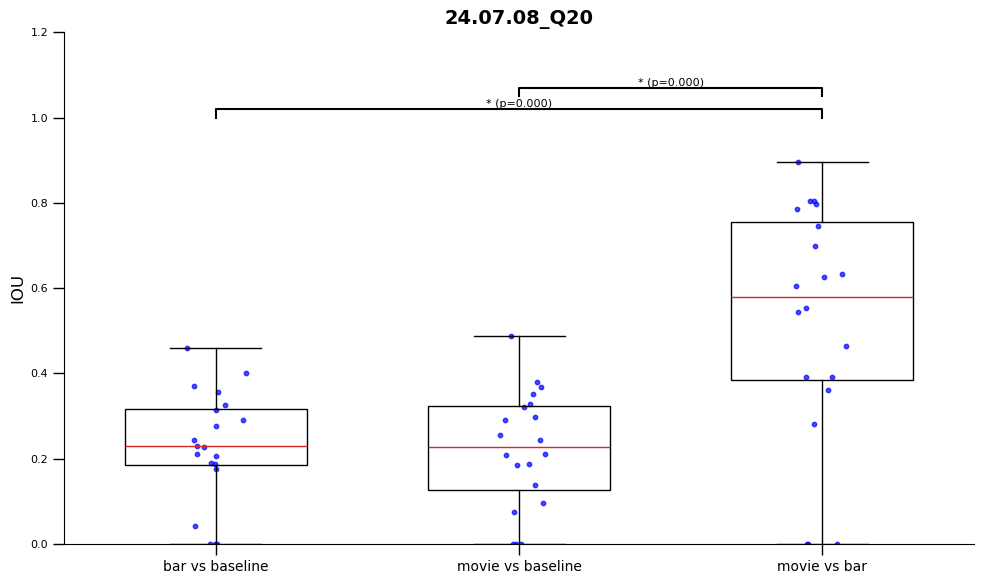

In [27]:
nat_base_bar_IOU = cal_list_IOU([base,bar,nat], ['baseline','bar','movie'])
nat_base_bar_IOU.to_csv('/home/lzx/data/WF_VC_liuzhaoxi/24.07.08_Q20/ICA_IOU(movie-baseline-bar).csv', index=True)
# plot_IOU(nat_base_bar_IOU, fig_path='/home/lzx/data/WF_VC_liuzhaoxi/24.07.08_Q20/ICA_IOU(movie-baseline-bar).png', fig_title='24.07.08_Q20', stat_test=0)
plot_IOU(nat_base_bar_IOU, fig_path='/home/lzx/data/WF_VC_liuzhaoxi/24.07.08_Q20/ICA_IOU(movie-baseline-bar)_stat.png', fig_title='24.07.08_Q20', stat_test=1, significance=0.05)